### Video Classification using only LSTM

เหมือนกับ ow_pooling แต่มีการ test accuracy on testing set

In [1]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import time
import mediapipe as mp 

import torch 
import torch.nn as nn
import torch.nn.functional as F

In [2]:
mp_holist = mp.solutions.holistic 
mp_draw = mp.solutions.drawing_utils

In [3]:
def mediapipe_detection(img, model):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img.flags.writeable = False                 
    result = model.process(img)                 # Make prediction
    img.flags.writeable = True                   
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR) 
    return img, result

In [4]:
def draw_landmarks(img, result):
    mp_draw.draw_landmarks(img, result.face_landmarks, mp_holist.FACEMESH_CONTOURS) # Draw face connections
    mp_draw.draw_landmarks(img, result.pose_landmarks, mp_holist.POSE_CONNECTIONS) # Draw pose connections
    mp_draw.draw_landmarks(img, result.left_hand_landmarks, mp_holist.HAND_CONNECTIONS) # Draw left hand connections
    mp_draw.draw_landmarks(img, result.right_hand_landmarks, mp_holist.HAND_CONNECTIONS) # Draw right hand connections

In [5]:
def draw_styled_landmarks(img, result):
    mp_draw.draw_landmarks(img, result.face_landmarks, mp_holist.FACEMESH_CONTOURS, 
                             mp_draw.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1), # color the joint 
                             mp_draw.DrawingSpec(color=(80,256,121), thickness=1, circle_radius=1) #color the connection
                             ) 
    # mp_draw.draw_landmarks(img, result.face_landmarks, mp_holist.FACEMESH_CONTOURS, 
    #                          mp_draw.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1), # color the joint 
    #                          mp_draw.DrawingSpec(color=(80,256,121), thickness=1, circle_radius=1) #color the connection
    #                          ) 
    
    mp_draw.draw_landmarks(img, result.pose_landmarks, mp_holist.POSE_CONNECTIONS,
                             mp_draw.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4), 
                             mp_draw.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2)
                             ) 
    mp_draw.draw_landmarks(img, result.left_hand_landmarks, mp_holist.HAND_CONNECTIONS, 
                             mp_draw.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4), 
                             mp_draw.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2)
                             ) 
    mp_draw.draw_landmarks(img, result.right_hand_landmarks, mp_holist.HAND_CONNECTIONS, 
                             mp_draw.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4), 
                             mp_draw.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                             ) 

In [6]:
mp_holist.POSE_CONNECTIONS

frozenset({(0, 1),
           (0, 4),
           (1, 2),
           (2, 3),
           (3, 7),
           (4, 5),
           (5, 6),
           (6, 8),
           (9, 10),
           (11, 12),
           (11, 13),
           (11, 23),
           (12, 14),
           (12, 24),
           (13, 15),
           (14, 16),
           (15, 17),
           (15, 19),
           (15, 21),
           (16, 18),
           (16, 20),
           (16, 22),
           (17, 19),
           (18, 20),
           (23, 24),
           (23, 25),
           (24, 26),
           (25, 27),
           (26, 28),
           (27, 29),
           (27, 31),
           (28, 30),
           (28, 32),
           (29, 31),
           (30, 32)})

In [7]:
def extract_keypoints(results):
    pose=np.array([[res.x,res.y,res.z,res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    left_hnd=np.array([[res.x,res.y,res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    right_hnd=np.array([[res.x,res.y,res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    face=np.array([[res.x,res.y,res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3)
    return np.concatenate([pose,left_hnd,right_hnd,face])
# concatenating for the model to detect the sign language

In [8]:
import os 
video_dir = "C:/Users/araya/Desktop/keypoints/video_extract"
video_list = []
video_list = os.listdir(video_dir)

len(video_list)

40

In [9]:
video_list

['กฎกระทรวง.mp4',
 'กฎหมายรัฐธรรมนูญ.mp4',
 'กรมอนามัย.mp4',
 'กรรม.mp4',
 'กรรมสิทธิ์.mp4',
 'กระโดด.mp4',
 'กล้วยบวชชี.mp4',
 'กล้วยเชื่อม.mp4',
 'กังวล.mp4',
 'กีฬา.mp4',
 'น้อง.mp4',
 'เขิน.mp4',
 'เขื่อนดิน.mp4',
 'เขื่อนสิริกิติ์.mp4',
 'เข้าใจผิด.mp4',
 'เคย.mp4',
 'เครียด.mp4',
 'เครื่องปั่นดิน.mp4',
 'เครื่องหมายการค้า.mp4',
 'เจอ.mp4',
 'เจ้าหนี้.mp4',
 'เช่าซื้อ.mp4',
 'เช่าทรัพย์.mp4',
 'เซอร์เบีย.mp4',
 'เซเนกัล.mp4',
 'เซ็ง.mp4',
 'เดิน.mp4',
 'เดิมพัน.mp4',
 'เพลีย.mp4',
 'เมื่อย.mp4',
 'เม็กซิโก.mp4',
 'เฮโรอีน.mp4',
 'แกมเบีย.mp4',
 'แซมเบีย.mp4',
 'โกหก.mp4',
 'โจทก์.mp4',
 'โชจู.mp4',
 'ใกล้.mp4',
 'ไดโนเสาร์.mp4',
 'ไอซ์.mp4']

In [10]:
# Path for exported data, numpy arrays
Model_Data=os.path.join('Data for different actions')

actions = np.array(video_list)

no_of_seqs = 1

# 30 frames in length
seq_length = 160

In [11]:
actions

array(['กฎกระทรวง.mp4', 'กฎหมายรัฐธรรมนูญ.mp4', 'กรมอนามัย.mp4',
       'กรรม.mp4', 'กรรมสิทธิ์.mp4', 'กระโดด.mp4', 'กล้วยบวชชี.mp4',
       'กล้วยเชื่อม.mp4', 'กังวล.mp4', 'กีฬา.mp4', 'น้อง.mp4', 'เขิน.mp4',
       'เขื่อนดิน.mp4', 'เขื่อนสิริกิติ์.mp4', 'เข้าใจผิด.mp4', 'เคย.mp4',
       'เครียด.mp4', 'เครื่องปั่นดิน.mp4', 'เครื่องหมายการค้า.mp4',
       'เจอ.mp4', 'เจ้าหนี้.mp4', 'เช่าซื้อ.mp4', 'เช่าทรัพย์.mp4',
       'เซอร์เบีย.mp4', 'เซเนกัล.mp4', 'เซ็ง.mp4', 'เดิน.mp4',
       'เดิมพัน.mp4', 'เพลีย.mp4', 'เมื่อย.mp4', 'เม็กซิโก.mp4',
       'เฮโรอีน.mp4', 'แกมเบีย.mp4', 'แซมเบีย.mp4', 'โกหก.mp4',
       'โจทก์.mp4', 'โชจู.mp4', 'ใกล้.mp4', 'ไดโนเสาร์.mp4', 'ไอซ์.mp4'],
      dtype='<U21')

Collecting keypoint values for Training nd Testing

In [12]:
# Define the directory where your videos are stored
directory = "C:/Users/araya/Desktop/keypoints/video_extract"

In [13]:
directory

'C:/Users/araya/Desktop/keypoints/video_extract'

In [14]:
for filename in actions:
    print(directory + '/' + filename)

C:/Users/araya/Desktop/keypoints/video_extract/กฎกระทรวง.mp4
C:/Users/araya/Desktop/keypoints/video_extract/กฎหมายรัฐธรรมนูญ.mp4
C:/Users/araya/Desktop/keypoints/video_extract/กรมอนามัย.mp4
C:/Users/araya/Desktop/keypoints/video_extract/กรรม.mp4
C:/Users/araya/Desktop/keypoints/video_extract/กรรมสิทธิ์.mp4
C:/Users/araya/Desktop/keypoints/video_extract/กระโดด.mp4
C:/Users/araya/Desktop/keypoints/video_extract/กล้วยบวชชี.mp4
C:/Users/araya/Desktop/keypoints/video_extract/กล้วยเชื่อม.mp4
C:/Users/araya/Desktop/keypoints/video_extract/กังวล.mp4
C:/Users/araya/Desktop/keypoints/video_extract/กีฬา.mp4
C:/Users/araya/Desktop/keypoints/video_extract/น้อง.mp4
C:/Users/araya/Desktop/keypoints/video_extract/เขิน.mp4
C:/Users/araya/Desktop/keypoints/video_extract/เขื่อนดิน.mp4
C:/Users/araya/Desktop/keypoints/video_extract/เขื่อนสิริกิติ์.mp4
C:/Users/araya/Desktop/keypoints/video_extract/เข้าใจผิด.mp4
C:/Users/araya/Desktop/keypoints/video_extract/เคย.mp4
C:/Users/araya/Desktop/keypoints/video_e

In [15]:
file_paths = []
for action in actions:
    video_path = os.path.join('Data for different actions/', action)
    # print(video_path)
    # print(action)
    file_paths.append(video_path + '/' + action.split(".")[0] + ".npy")
print(file_paths)

['Data for different actions/กฎกระทรวง.mp4/กฎกระทรวง.npy', 'Data for different actions/กฎหมายรัฐธรรมนูญ.mp4/กฎหมายรัฐธรรมนูญ.npy', 'Data for different actions/กรมอนามัย.mp4/กรมอนามัย.npy', 'Data for different actions/กรรม.mp4/กรรม.npy', 'Data for different actions/กรรมสิทธิ์.mp4/กรรมสิทธิ์.npy', 'Data for different actions/กระโดด.mp4/กระโดด.npy', 'Data for different actions/กล้วยบวชชี.mp4/กล้วยบวชชี.npy', 'Data for different actions/กล้วยเชื่อม.mp4/กล้วยเชื่อม.npy', 'Data for different actions/กังวล.mp4/กังวล.npy', 'Data for different actions/กีฬา.mp4/กีฬา.npy', 'Data for different actions/น้อง.mp4/น้อง.npy', 'Data for different actions/เขิน.mp4/เขิน.npy', 'Data for different actions/เขื่อนดิน.mp4/เขื่อนดิน.npy', 'Data for different actions/เขื่อนสิริกิติ์.mp4/เขื่อนสิริกิติ์.npy', 'Data for different actions/เข้าใจผิด.mp4/เข้าใจผิด.npy', 'Data for different actions/เคย.mp4/เคย.npy', 'Data for different actions/เครียด.mp4/เครียด.npy', 'Data for different actions/เครื่องปั่นดิน.mp4/เครื

In [16]:
def load_keypoint_sequences(file_paths):
    keypoint_sequences = []
    for file_path in file_paths:
        keypoints = np.load(file_path)
        keypoint_sequences.append(torch.tensor(keypoints, dtype=torch.float32))
    return keypoint_sequences

In [17]:
# Load the sequences
import torch
sequences = load_keypoint_sequences(file_paths)
sequences

[tensor([[ 0.5013,  0.2452, -1.2167,  ...,  0.5663,  0.2188,  0.0098],
         [ 0.4997,  0.2482, -1.4690,  ...,  0.5652,  0.2181,  0.0106],
         [ 0.4984,  0.2500, -1.4853,  ...,  0.5654,  0.2185,  0.0112],
         ...,
         [ 0.4861,  0.2513, -1.3416,  ...,  0.5572,  0.2177,  0.0091],
         [ 0.4873,  0.2514, -1.3574,  ...,  0.5575,  0.2172,  0.0097],
         [ 0.4883,  0.2516, -1.3579,  ...,  0.5577,  0.2170,  0.0101]]),
 tensor([[ 0.4922,  0.2382, -1.2850,  ...,  0.5578,  0.2124,  0.0094],
         [ 0.4920,  0.2405, -1.4288,  ...,  0.5571,  0.2116,  0.0099],
         [ 0.4920,  0.2409, -1.4093,  ...,  0.5567,  0.2122,  0.0098],
         ...,
         [ 0.4814,  0.2260, -1.3318,  ...,  0.5503,  0.1923,  0.0123],
         [ 0.4815,  0.2257, -1.3351,  ...,  0.5503,  0.1921,  0.0122],
         [ 0.4815,  0.2255, -1.3497,  ...,  0.5501,  0.1919,  0.0124]]),
 tensor([[ 0.5049,  0.2371, -1.2115,  ...,  0.5643,  0.2082,  0.0088],
         [ 0.5045,  0.2381, -1.1896,  ...,  0

In [18]:
# Pad the sequences to the same length
from torch.nn.utils.rnn import pad_sequence
padded_sequences = pad_sequence(sequences, batch_first=True)
pad_sequence
print(padded_sequences.shape) # (batch_size, max_sequence_length, num_keypoints)

torch.Size([40, 160, 1662])


In [19]:
labels = [action.split(".")[0] for action in actions]
labels

['กฎกระทรวง',
 'กฎหมายรัฐธรรมนูญ',
 'กรมอนามัย',
 'กรรม',
 'กรรมสิทธิ์',
 'กระโดด',
 'กล้วยบวชชี',
 'กล้วยเชื่อม',
 'กังวล',
 'กีฬา',
 'น้อง',
 'เขิน',
 'เขื่อนดิน',
 'เขื่อนสิริกิติ์',
 'เข้าใจผิด',
 'เคย',
 'เครียด',
 'เครื่องปั่นดิน',
 'เครื่องหมายการค้า',
 'เจอ',
 'เจ้าหนี้',
 'เช่าซื้อ',
 'เช่าทรัพย์',
 'เซอร์เบีย',
 'เซเนกัล',
 'เซ็ง',
 'เดิน',
 'เดิมพัน',
 'เพลีย',
 'เมื่อย',
 'เม็กซิโก',
 'เฮโรอีน',
 'แกมเบีย',
 'แซมเบีย',
 'โกหก',
 'โจทก์',
 'โชจู',
 'ใกล้',
 'ไดโนเสาร์',
 'ไอซ์']

In [20]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

labels = le.fit_transform(labels)
labels

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39], dtype=int64)

In [21]:
# import pandas as pd
# y = pd.read_csv("script.csv")
# y

In [22]:
# y["label"] = y["label"].astype(int)
# labels = y.label
# labels

In [23]:
import torch
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence

# Create a custom dataset
class KeypointDataset(Dataset):
    def __init__(self, file_paths, labels):
        self.file_paths = file_paths
        self.labels = labels
    
    def __len__(self):
        return len(self.file_paths)
    
    def __getitem__(self, idx):
        keypoints = np.load(self.file_paths[idx])
        label = self.labels[idx]
        return torch.tensor(keypoints, dtype=torch.float32), label

In [24]:
# Create the dataset
dataset = KeypointDataset(file_paths, labels)

In [25]:
print(dataset.file_paths)
print(dataset.labels)

['Data for different actions/กฎกระทรวง.mp4/กฎกระทรวง.npy', 'Data for different actions/กฎหมายรัฐธรรมนูญ.mp4/กฎหมายรัฐธรรมนูญ.npy', 'Data for different actions/กรมอนามัย.mp4/กรมอนามัย.npy', 'Data for different actions/กรรม.mp4/กรรม.npy', 'Data for different actions/กรรมสิทธิ์.mp4/กรรมสิทธิ์.npy', 'Data for different actions/กระโดด.mp4/กระโดด.npy', 'Data for different actions/กล้วยบวชชี.mp4/กล้วยบวชชี.npy', 'Data for different actions/กล้วยเชื่อม.mp4/กล้วยเชื่อม.npy', 'Data for different actions/กังวล.mp4/กังวล.npy', 'Data for different actions/กีฬา.mp4/กีฬา.npy', 'Data for different actions/น้อง.mp4/น้อง.npy', 'Data for different actions/เขิน.mp4/เขิน.npy', 'Data for different actions/เขื่อนดิน.mp4/เขื่อนดิน.npy', 'Data for different actions/เขื่อนสิริกิติ์.mp4/เขื่อนสิริกิติ์.npy', 'Data for different actions/เข้าใจผิด.mp4/เข้าใจผิด.npy', 'Data for different actions/เคย.mp4/เคย.npy', 'Data for different actions/เครียด.mp4/เครียด.npy', 'Data for different actions/เครื่องปั่นดิน.mp4/เครื

In [26]:
# Collate function for padding
def collate_fn(batch):
    sequences, labels = zip(*batch)
    padded_sequences = pad_sequence(sequences, batch_first=True)
    return padded_sequences, torch.tensor(labels)

In [27]:
# Create the DataLoader
batch_size = 4
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
data_loader

In [28]:
# Set device (use GPU if available)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [29]:
import torch
import torch.nn as nn
import torch.optim as optim

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes,dropout):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc1 = nn.Linear(hidden_size, 256)
        self.fc2 = nn.Linear(256, num_classes)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x):
        # h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        # c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        # Forward propagate the LSTM
        out, _ = self.lstm(self.dropout(x))
        
        # Use the last time step's output for classification
        out = out[:, -1, :]
        out = self.fc1(out)
        out = self.fc2(out)
        return out

In [30]:
# Initialize the model, loss function, and optimizer
model = LSTMModel(input_size=1662, hidden_size=256, num_layers=2, num_classes=40, dropout=0.5).to(device)

In [31]:
criterion = nn.CrossEntropyLoss()  # For multi-class classification
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [32]:
# Training loop
# References : https://saturncloud.io/blog/calculating-the-accuracy-of-pytorch-models-every-epoch/#:~:text=In%20order%20to%20calculate%20the,tensor%20along%20a%20specified%20dimension
num_epochs = 900
loss_logger = []
accuracy_logger = []
# n_epochs = []
for epoch in range(num_epochs):
    total_correct = 0
    total_samples = 0
    model.train()
    for i, (sequences, labels) in enumerate(data_loader):
        # Move data to the device
        # labels = labels.type(torch.LongTensor)   # casting to long
        sequences = sequences.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(sequences)
        _, predicted = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        total_correct += (predicted == labels).sum().item()
        total_samples += labels.size(0)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # loss_logger.append(loss.item())
    loss_logger.append(loss.item())
    accuracy = 100 * total_correct /total_samples
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f} , Accuracy : {accuracy:.2f}%')
    accuracy_logger.append(accuracy)
    # n_epochs.append(epoch)

Epoch [1/900], Loss: 3.8080 , Accuracy : 0.00%
Epoch [2/900], Loss: 3.5543 , Accuracy : 5.00%
Epoch [3/900], Loss: 3.6939 , Accuracy : 0.00%
Epoch [4/900], Loss: 3.7798 , Accuracy : 0.00%
Epoch [5/900], Loss: 3.4380 , Accuracy : 0.00%
Epoch [6/900], Loss: 3.3660 , Accuracy : 0.00%
Epoch [7/900], Loss: 3.4729 , Accuracy : 2.50%
Epoch [8/900], Loss: 3.8530 , Accuracy : 2.50%
Epoch [9/900], Loss: 3.1126 , Accuracy : 2.50%
Epoch [10/900], Loss: 3.5003 , Accuracy : 2.50%
Epoch [11/900], Loss: 3.5388 , Accuracy : 0.00%
Epoch [12/900], Loss: 3.5350 , Accuracy : 5.00%
Epoch [13/900], Loss: 4.0712 , Accuracy : 0.00%
Epoch [14/900], Loss: 3.2869 , Accuracy : 0.00%
Epoch [15/900], Loss: 4.0435 , Accuracy : 2.50%
Epoch [16/900], Loss: 3.8471 , Accuracy : 5.00%
Epoch [17/900], Loss: 3.9329 , Accuracy : 0.00%
Epoch [18/900], Loss: 4.2576 , Accuracy : 5.00%
Epoch [19/900], Loss: 3.0819 , Accuracy : 2.50%
Epoch [20/900], Loss: 3.5575 , Accuracy : 5.00%
Epoch [21/900], Loss: 3.1717 , Accuracy : 5.00%
E

In [33]:
loss_logger

[3.807985782623291,
 3.5543153285980225,
 3.6938700675964355,
 3.7798373699188232,
 3.4379940032958984,
 3.3659777641296387,
 3.4729361534118652,
 3.8529720306396484,
 3.1125736236572266,
 3.500269651412964,
 3.538846015930176,
 3.5349607467651367,
 4.071152210235596,
 3.286867618560791,
 4.043452262878418,
 3.8470587730407715,
 3.9329142570495605,
 4.257632255554199,
 3.0819361209869385,
 3.557467460632324,
 3.171738386154175,
 3.1953210830688477,
 3.4194090366363525,
 3.0152740478515625,
 2.9949052333831787,
 2.792753219604492,
 3.3723907470703125,
 3.313932180404663,
 3.0505902767181396,
 2.760096311569214,
 3.7009379863739014,
 2.9974656105041504,
 2.7735791206359863,
 3.1596291065216064,
 3.1864795684814453,
 3.016505718231201,
 2.646651268005371,
 3.404559373855591,
 3.2035999298095703,
 2.110816717147827,
 3.7405707836151123,
 3.220857620239258,
 3.0702767372131348,
 2.787964344024658,
 3.4448084831237793,
 3.6531319618225098,
 3.1321349143981934,
 3.1756722927093506,
 2.9876184

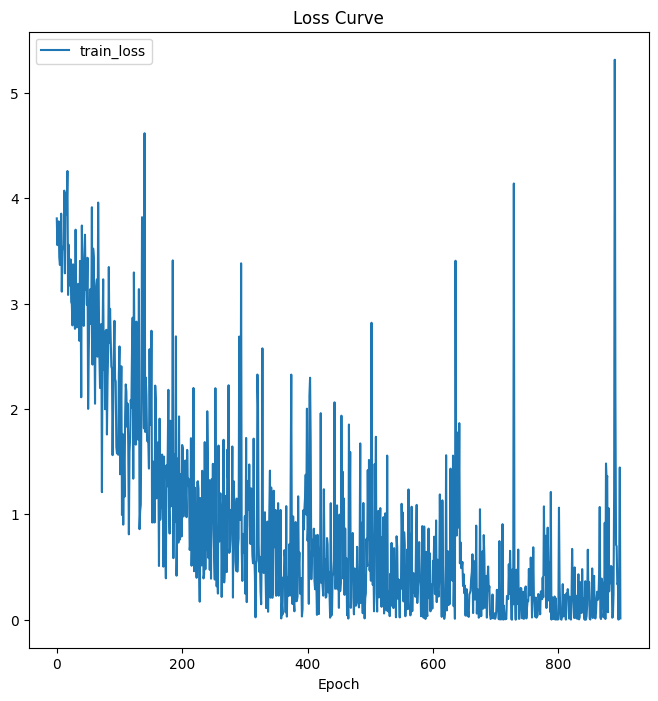

In [67]:
from matplotlib import pyplot as plt
plt.figure(figsize=(8,8))
plt.title("Loss Curve")
plt.plot(loss_logger, label='train_loss')
# plt.plot(accuracy_logger,label='accuracy')
plt.xlabel("Epoch")
plt.legend()
plt.show()

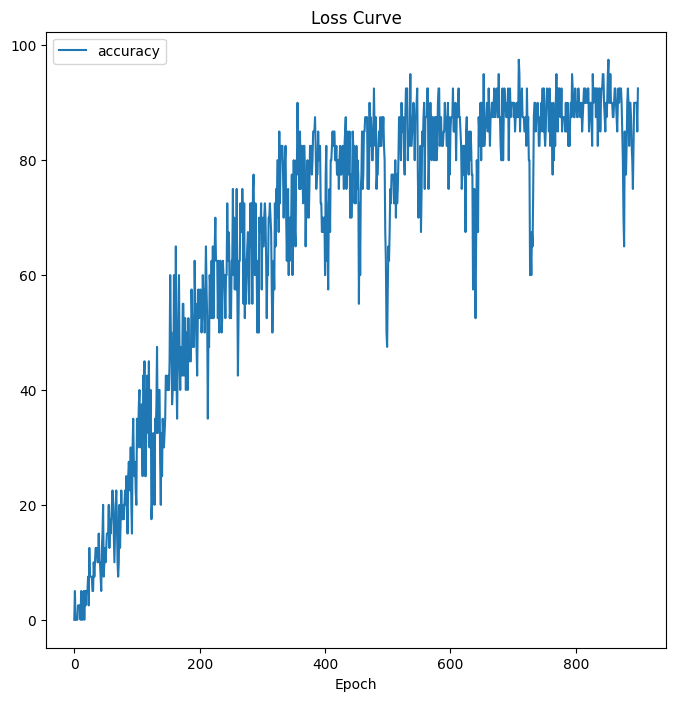

In [66]:
from matplotlib import pyplot as plt
plt.figure(figsize=(8,8))
plt.title("Loss Curve")
# plt.plot(loss_logger, label='train_loss')
plt.plot(accuracy_logger,label='accuracy')
plt.xlabel("Epoch")
plt.legend()
plt.show()

### Save and Load Model

In [39]:
pad_sequence(sequences, batch_first=True)

tensor([[[ 0.5103,  0.2428, -1.1660,  ...,  0.5757,  0.2179,  0.0081],
         [ 0.5106,  0.2437, -1.2850,  ...,  0.5751,  0.2183,  0.0099],
         [ 0.5112,  0.2443, -1.2880,  ...,  0.5748,  0.2189,  0.0108],
         ...,
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],

        [[ 0.5122,  0.2456, -1.3706,  ...,  0.5836,  0.2207,  0.0125],
         [ 0.5121,  0.2461, -1.4417,  ...,  0.5818,  0.2208,  0.0118],
         [ 0.5121,  0.2465, -1.4591,  ...,  0.5815,  0.2204,  0.0118],
         ...,
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],

        [[ 0.5016,  0.2321, -1.1859,  ...,  0.5647,  0.2139,  0.0072],
         [ 0.5015,  0.2340, -1.1996,  ...,  0

In [40]:
# Put the model in evaluation mode
model.eval()

# No need to track gradients during inference
with torch.no_grad():
    # Get the model's output (logits)
    outputs = model(padded_sequences.to(device))

# outputs = torch.softmax(outputs, dim=1)
# outputs = torch.max(outputs,1)

outputs


tensor([[ 17.4211,   0.9670,  -6.0845,  ...,  -2.2224,  -0.3210,   4.8906],
        [ -0.2936,  20.6474,  -7.7237,  ...,  11.6223, -17.3149, -13.7611],
        [ -6.5771,  -2.1881,  25.1982,  ...,  -6.2709,   5.8925,   4.4333],
        ...,
        [ -6.0157,  10.5159,  -9.6470,  ...,  18.7268, -10.7150,  -9.7125],
        [  1.1419, -10.0961,   1.9100,  ...,  -5.8023,  16.1515,  10.7780],
        [  2.7909, -11.3903,   3.4918,  ...,  -7.1983,   9.8100,  17.7750]],
       device='cuda:0')

In [41]:
padded_sequences

tensor([[[ 0.5013,  0.2452, -1.2167,  ...,  0.5663,  0.2188,  0.0098],
         [ 0.4997,  0.2482, -1.4690,  ...,  0.5652,  0.2181,  0.0106],
         [ 0.4984,  0.2500, -1.4853,  ...,  0.5654,  0.2185,  0.0112],
         ...,
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],

        [[ 0.4922,  0.2382, -1.2850,  ...,  0.5578,  0.2124,  0.0094],
         [ 0.4920,  0.2405, -1.4288,  ...,  0.5571,  0.2116,  0.0099],
         [ 0.4920,  0.2409, -1.4093,  ...,  0.5567,  0.2122,  0.0098],
         ...,
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],

        [[ 0.5049,  0.2371, -1.2115,  ...,  0.5643,  0.2082,  0.0088],
         [ 0.5045,  0.2381, -1.1896,  ...,  0

In [52]:
file_paths = ["Data for different actions/กระโดด_2.mp4/กระโดด_2.npy"]

In [53]:
# Load the sequences
import torch
sequences = load_keypoint_sequences(file_paths)
# Change list to numpy array 
sequences = np.array(sequences)
# Change numpy array to tensor
sequences = torch.FloatTensor(sequences)
sequences = pad_sequence(sequences, batch_first=True)
sequences

tensor([[[ 0.4892,  0.2026, -1.2242,  ...,  0.5473,  0.1618,  0.0127],
         [ 0.4892,  0.2024, -1.2833,  ...,  0.5469,  0.1620,  0.0112],
         [ 0.4891,  0.2024, -1.2910,  ...,  0.5464,  0.1621,  0.0116],
         ...,
         [ 0.5013,  0.1914, -1.3045,  ...,  0.5641,  0.1515,  0.0174],
         [ 0.5027,  0.1912, -1.3482,  ...,  0.5654,  0.1514,  0.0174],
         [ 0.5038,  0.1912, -1.3433,  ...,  0.5661,  0.1511,  0.0175]]])

In [54]:
outputs = model(sequences.to(device))
outputs

tensor([[  4.8091,   7.0829,  -8.3748,  -7.2665,  -3.5691,   0.1914,   4.3419,
          -4.3820, -10.1708,  -2.9447,  -8.6955,  -8.1446,  11.3651,  -1.2578,
          -0.2301,  -1.5071,  16.9856,  -3.4521,  -6.0205,   6.4875,  11.5345,
           1.9979,  -4.7703,  -5.9088,  11.2005,  -6.0467,   0.9693,   3.7092,
          -6.2460,   9.2707,   4.1555,  -0.6813,  -6.8468,  -3.8219,  -3.3857,
           8.8964,  -9.1380,   0.8509, -12.1382, -12.0310]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

In [55]:
labels = [action.split(".")[0] for action in actions]
labels

['กฎกระทรวง',
 'กฎหมายรัฐธรรมนูญ',
 'กรมอนามัย',
 'กรรม',
 'กรรมสิทธิ์',
 'กระโดด',
 'กล้วยบวชชี',
 'กล้วยเชื่อม',
 'กังวล',
 'กีฬา',
 'น้อง',
 'เขิน',
 'เขื่อนดิน',
 'เขื่อนสิริกิติ์',
 'เข้าใจผิด',
 'เคย',
 'เครียด',
 'เครื่องปั่นดิน',
 'เครื่องหมายการค้า',
 'เจอ',
 'เจ้าหนี้',
 'เช่าซื้อ',
 'เช่าทรัพย์',
 'เซอร์เบีย',
 'เซเนกัล',
 'เซ็ง',
 'เดิน',
 'เดิมพัน',
 'เพลีย',
 'เมื่อย',
 'เม็กซิโก',
 'เฮโรอีน',
 'แกมเบีย',
 'แซมเบีย',
 'โกหก',
 'โจทก์',
 'โชจู',
 'ใกล้',
 'ไดโนเสาร์',
 'ไอซ์']

In [56]:
# Change from tensor to numpy arrat
outputs = outputs.cpu().detach().numpy()

In [57]:
outputs

array([[  4.809122  ,   7.0828905 ,  -8.374796  ,  -7.2664557 ,
         -3.5690842 ,   0.19144548,   4.3418736 ,  -4.3819523 ,
        -10.170769  ,  -2.9446573 ,  -8.695516  ,  -8.144629  ,
         11.365085  ,  -1.257783  ,  -0.2301486 ,  -1.5070608 ,
         16.985603  ,  -3.452105  ,  -6.020537  ,   6.4875054 ,
         11.534495  ,   1.9979432 ,  -4.770283  ,  -5.908824  ,
         11.200544  ,  -6.046668  ,   0.9692975 ,   3.7091765 ,
         -6.2460427 ,   9.270735  ,   4.155515  ,  -0.68125254,
         -6.846818  ,  -3.8219147 ,  -3.3857458 ,   8.896409  ,
         -9.137982  ,   0.85087174, -12.138206  , -12.031025  ]],
      dtype=float32)

In [58]:
for idx, word in enumerate(outputs):
    # max_value = torch.max(outputs)
    list_outputs = max(outputs)
    print(list_outputs)
    # print(max_value)
    # print(max_value.detach().numpy())

[  4.809122     7.0828905   -8.374796    -7.2664557   -3.5690842
   0.19144548   4.3418736   -4.3819523  -10.170769    -2.9446573
  -8.695516    -8.144629    11.365085    -1.257783    -0.2301486
  -1.5070608   16.985603    -3.452105    -6.020537     6.4875054
  11.534495     1.9979432   -4.770283    -5.908824    11.200544
  -6.046668     0.9692975    3.7091765   -6.2460427    9.270735
   4.155515    -0.68125254  -6.846818    -3.8219147   -3.3857458
   8.896409    -9.137982     0.85087174 -12.138206   -12.031025  ]


In [59]:
index_max = max(range(len(list_outputs)), key=list_outputs.__getitem__)
index_max

16

In [60]:
print(labels[index_max])

เครียด


In [61]:
correct = 0
num_clip = 0
for clip in labels:
    # print(clip)
    file_paths = [f"Data for different actions/{clip}.mp4/{clip}.npy"]
    # print(file_paths)

    sequences = load_keypoint_sequences(file_paths)
    # Change list to numpy array 
    sequences = np.array(sequences)
    # Change numpy array to tensor
    sequences = torch.FloatTensor(sequences)
    sequences = pad_sequence(sequences, batch_first=True)

    outputs = model(sequences.to(device))

    for idx, word in enumerate(outputs):
        # max_value = torch.max(outputs)
        list_outputs = max(outputs)

    index_max = max(range(len(list_outputs)), key=list_outputs.__getitem__)

    print(f"Input : {clip} Predicted : {labels[index_max]}")

    if clip == labels[index_max]:
        correct = correct+1
    
    num_clip = num_clip + 1 

print(f"Correct Predicted on Training set : {correct} Corrct percentage : {correct*100/num_clip}%")

Input : กฎกระทรวง Predicted : กฎกระทรวง
Input : กฎหมายรัฐธรรมนูญ Predicted : กฎหมายรัฐธรรมนูญ
Input : กรมอนามัย Predicted : กรมอนามัย
Input : กรรม Predicted : กรรม
Input : กรรมสิทธิ์ Predicted : เครื่องปั่นดิน
Input : กระโดด Predicted : กระโดด
Input : กล้วยบวชชี Predicted : กล้วยบวชชี
Input : กล้วยเชื่อม Predicted : กล้วยเชื่อม
Input : กังวล Predicted : กังวล
Input : กีฬา Predicted : กีฬา
Input : น้อง Predicted : น้อง
Input : เขิน Predicted : กรรม
Input : เขื่อนดิน Predicted : เขื่อนดิน
Input : เขื่อนสิริกิติ์ Predicted : เขื่อนสิริกิติ์
Input : เข้าใจผิด Predicted : เข้าใจผิด
Input : เคย Predicted : เดิน
Input : เครียด Predicted : เครียด
Input : เครื่องปั่นดิน Predicted : เครื่องปั่นดิน
Input : เครื่องหมายการค้า Predicted : เครื่องหมายการค้า
Input : เจอ Predicted : เขื่อนดิน
Input : เจ้าหนี้ Predicted : เจ้าหนี้
Input : เช่าซื้อ Predicted : เช่าซื้อ
Input : เช่าทรัพย์ Predicted : เช่าทรัพย์
Input : เซอร์เบีย Predicted : เซอร์เบีย
Input : เซเนกัล Predicted : โจทก์
Input : เซ็ง Predicte

In [62]:
print(labels)

['กฎกระทรวง', 'กฎหมายรัฐธรรมนูญ', 'กรมอนามัย', 'กรรม', 'กรรมสิทธิ์', 'กระโดด', 'กล้วยบวชชี', 'กล้วยเชื่อม', 'กังวล', 'กีฬา', 'น้อง', 'เขิน', 'เขื่อนดิน', 'เขื่อนสิริกิติ์', 'เข้าใจผิด', 'เคย', 'เครียด', 'เครื่องปั่นดิน', 'เครื่องหมายการค้า', 'เจอ', 'เจ้าหนี้', 'เช่าซื้อ', 'เช่าทรัพย์', 'เซอร์เบีย', 'เซเนกัล', 'เซ็ง', 'เดิน', 'เดิมพัน', 'เพลีย', 'เมื่อย', 'เม็กซิโก', 'เฮโรอีน', 'แกมเบีย', 'แซมเบีย', 'โกหก', 'โจทก์', 'โชจู', 'ใกล้', 'ไดโนเสาร์', 'ไอซ์']


### Save Model

In [64]:
torch.save(model.state_dict(), 'saved_data/lstm.pt')
torch.save(optimizer.state_dict(), 'saved_data/lstm_optimizer.pt')
# torch.save(scheduler.state_dict(), 'saved_data/scheduler.pt')

### -------------------------------------------------------------------------------------------------------------------------------------------- ###

In [498]:
import pandas as pd

In [ ]:
video_list

In [500]:
columns = ["word"]

In [ ]:
pd.DataFrame(video_list, columns=columns)

ชื่อไฟลล์ที่รวม Augment มาด้วย

In [502]:
from os import listdir
from os.path import isfile, join
onlyfiles = [f for f in listdir("Data for different actions")]

In [ ]:
onlyfiles

In [ ]:
df = pd.DataFrame(onlyfiles, columns=columns)
df

In [505]:
df.to_csv('script.csv', index=False)

### Read File

In [ ]:
y = pd.read_csv("script.csv")
y

In [ ]:
y["label"] = y["label"].astype(int)
labels = y.label
labels